In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from shapely.geometry import Point
import copy
import time

In [2]:
# TO DO
# Alter packing metric: Probably need to define something else which will penalise "holes"
# Converge with emcee: Arbitrary input values for each geog, then sort, and use the sort order to define place on grid

In [3]:
geodata = gpd.read_file('./Data/LADs.geojson').to_crs('epsg:27700')
# geodata = geodata[['E09' in c for c in geodata['LAD20CD']]][['LAD20CD', 'LAD20NM', 'geometry']]
geodata = geodata[['W' in c for c in geodata['LAD20CD']]][['LAD20CD', 'LAD20NM', 'geometry']]
geodata['dummy'] = geodata['geometry'].apply(lambda g: 1)

In [4]:
geodata['centroid'] = geodata.centroid

In [5]:
geodata

,LAD20CD,LAD20NM,geometry,dummy,centroid
357,W06000001,Isle of Anglesey,"POLYGON ((240000.004 394577.908, 240445.514 39...",1,POINT (241835.228 379233.676)
358,W06000002,Gwynedd,"MULTIPOLYGON (((267978.708 372366.304, 270868....",1,POINT (264136.399 334667.737)
359,W06000003,Conwy,"POLYGON ((299724.870 380889.607, 300371.113 37...",1,POINT (284072.324 361552.108)
360,W06000004,Denbighshire,"POLYGON ((324414.214 353387.707, 323145.711 35...",1,POINT (309507.880 355562.623)
361,W06000005,Flintshire,"MULTIPOLYGON (((313293.515 382786.601, 315287....",1,POINT (322547.437 368615.133)
362,W06000006,Wrexham,"POLYGON ((351298.712 343127.004, 350716.010 34...",1,POINT (331695.185 344175.768)
363,W06000008,Ceredigion,"POLYGON ((279749.210 249226.602, 277768.013 24...",1,POINT (258559.569 263733.729)
364,W06000009,Pembrokeshire,"MULTIPOLYGON (((216364.016 243983.404, 217396....",1,POINT (201337.424 221180.436)
365,W06000010,Carmarthenshire,"POLYGON ((279749.210 249226.602, 282307.116 24...",1,POINT (251556.904 225139.754)
366,W06000011,Swansea,"MULTIPOLYGON (((262123.115 210278.302, 264479....",1,POINT (258170.595 195828.191)


<AxesSubplot:>

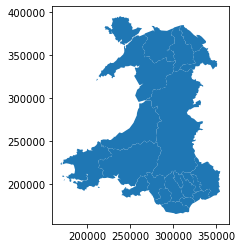

In [6]:
geodata.plot()

In [7]:
neighbours = geodata.sjoin(geodata, how='inner', predicate='touches')
neighbours = neighbours.loc[neighbours['LAD20CD_left']!=neighbours['LAD20CD_right']]

In [8]:
def angle_between(loca, locb):
    xa, ya = loca.xy
    xb, yb = locb.xy    
    return np.arctan2(yb[0]-ya[0], xb[0]-xa[0])

neighbours['target_angle'] = neighbours.apply(lambda row: angle_between(row['centroid_left'], row['centroid_right']), axis=1)
neighbours = neighbours[['LAD20CD_left', 'LAD20CD_right', 'target_angle']]

In [9]:
neighbours

,LAD20CD_left,LAD20CD_right,target_angle
358,W06000002,W06000004,0.431575
359,W06000003,W06000004,-0.231264
361,W06000005,W06000004,-2.355698
362,W06000006,W06000004,2.667429
377,W06000023,W06000004,1.505988
...,...,...,...
377,W06000023,W06000019,-1.354165
373,W06000019,W06000021,-0.017100
374,W06000020,W06000021,0.527129
376,W06000022,W06000021,1.255565


In [10]:
crossjoin = geodata.merge(geodata, how='inner', on='dummy', suffixes=('_left', '_right'))
crossjoin = crossjoin.loc[crossjoin['LAD20CD_left']!=crossjoin['LAD20CD_right']]
crossjoin['distance'] = crossjoin.apply(lambda row: row['geometry_left'].distance(row['geometry_right']), axis=1)
crossjoin['target_distance_rank'] = crossjoin.groupby('LAD20CD_left')['distance'].rank()
crossjoin['target_angle'] = crossjoin.apply(lambda row: angle_between(row['centroid_left'], row['centroid_right']), axis=1)
distance_ranking = crossjoin[['LAD20CD_left', 'LAD20CD_right', 'target_distance_rank', 'target_angle']]

In [11]:
distance_ranking

,LAD20CD_left,LAD20CD_right,target_distance_rank,target_angle
1,W06000001,W06000002,1.0,-1.106822
2,W06000001,W06000003,2.0,-0.396460
3,W06000001,W06000004,3.0,-0.336486
4,W06000001,W06000005,4.0,-0.130809
5,W06000001,W06000006,6.0,-0.371977
...,...,...,...,...
478,W06000024,W06000019,4.0,0.220886
479,W06000024,W06000020,7.0,-0.237013
480,W06000024,W06000021,9.0,0.065829
481,W06000024,W06000022,10.0,-0.597980


In [12]:
distance_ranking

,LAD20CD_left,LAD20CD_right,target_distance_rank,target_angle
1,W06000001,W06000002,1.0,-1.106822
2,W06000001,W06000003,2.0,-0.396460
3,W06000001,W06000004,3.0,-0.336486
4,W06000001,W06000005,4.0,-0.130809
5,W06000001,W06000006,6.0,-0.371977
...,...,...,...,...
478,W06000024,W06000019,4.0,0.220886
479,W06000024,W06000020,7.0,-0.237013
480,W06000024,W06000021,9.0,0.065829
481,W06000024,W06000022,10.0,-0.597980


In [13]:
orientation_ranking = copy.copy(geodata)[['LAD20CD', 'centroid']]
orientation_ranking['x'] = orientation_ranking['centroid'].apply(lambda c: c.xy[0][0])
orientation_ranking['y'] = orientation_ranking['centroid'].apply(lambda c: c.xy[1][0])
orientation_ranking['EW'] = orientation_ranking['x'].rank()
orientation_ranking['NS'] = orientation_ranking['y'].rank()
orientation_ranking = orientation_ranking[['LAD20CD', 'EW', 'NS']]

In [14]:
orientation_ranking

,LAD20CD,EW,NS
357,W06000001,2.0,22.0
358,W06000002,6.0,17.0
359,W06000003,8.0,20.0
360,W06000004,14.0,19.0
361,W06000005,18.0,21.0
362,W06000006,20.0,18.0
363,W06000008,5.0,15.0
364,W06000009,1.0,13.0
365,W06000010,3.0,14.0
366,W06000011,4.0,7.0


In [15]:
# Create an initial grid

scale_factor = 0
sfs = [scale_factor]
scale_factor_interval = len(geodata)/200

initial_grid_size = -1
gss = [initial_grid_size]
full_bounds = geodata.total_bounds
axis_ratio = (full_bounds[3]-full_bounds[1])/(full_bounds[2]-full_bounds[0])

while initial_grid_size < len(geodata):

    scale_factor += scale_factor_interval
    
    initial_y_length = int(np.round(scale_factor*np.sqrt(len(geodata)/axis_ratio), decimals=0))
    initial_x_length = int(np.round(axis_ratio*initial_y_length))

    initial_grid = np.meshgrid(range(initial_x_length), range(initial_x_length))
    initial_grid_size = initial_y_length*initial_x_length
    
    sfs.append(scale_factor)
    gss.append(initial_grid_size)

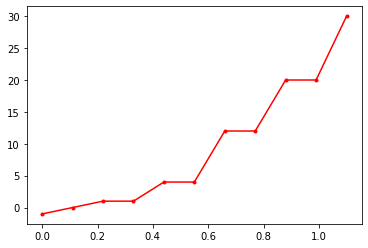

In [16]:
plt.plot(sfs, gss, 'r.-')

In [45]:
neighbour_distance_factor = 6
# neighbour_angle_factor = 0

proximity_distance_factor = 3
# proximity_angle_factor = 0

packing_factor = 5

orientation_factor = 8

max_move_jump = 1


def generate_geodataframe(codes, coords):
    
    grid_pdf = pd.DataFrame({
        'code': codes,
        'y': coords[0],
        'x': coords[1]
    })
    grid_gdf = gpd.GeoDataFrame(grid_pdf, geometry=gpd.points_from_xy(grid_pdf['x'], grid_pdf['y']))
    grid_gdf.crs = 'epsg:27700'
    
    return grid_gdf[['code', 'geometry']]


def angle_difference(angle1, angle2):
    d = angle2-angle1
    d = d+(2*np.pi) if d < -np.pi else d
    d = d-(2*np.pi) if d > np.pi else d
    return d


def neighbour_metric(it_gdf):
    
     # Find the distances and angles to all the neighbours
    it_neighbours = it_gdf.merge(neighbours, left_on='code', right_on='LAD20CD_left')
    it_neighbours = it_neighbours.merge(it_gdf, left_on='LAD20CD_right', right_on='code', suffixes=('', '_r'))
    it_neighbours = it_neighbours[['code', 'geometry', 'code_r', 'geometry_r', 'target_angle']]

    it_neighbours['distance'] = it_neighbours.apply(lambda row: row['geometry'].distance(row['geometry_r']), axis=1)
#     it_neighbours['angle'] = it_neighbours.apply(lambda row: angle_between(row['geometry'], row['geometry_r']), axis=1)
#     it_neighbours['angle_diff'] = it_neighbours.apply(lambda row: angle_difference(row['angle'], row['target_angle']), axis=1)

    # Define the neighbour metric
#     it_neighbours['neighbour_metric'] = it_neighbours.apply(lambda row: (neighbour_distance_factor*row['distance']**2)+(neighbour_angle_factor*row['angle_diff']**2), axis=1)
    it_neighbours['neighbour_metric'] = it_neighbours.apply(lambda row: neighbour_distance_factor*row['distance']**2, axis=1)
    neighbour_metric = it_neighbours.groupby('code')['neighbour_metric'].sum().reset_index()
#     it_gdf = it_gdf.merge(neighbour_metric, on='code', how='left').fillna(0)
    
    return neighbour_metric


def proximity_metric(it_gdf):
    
    # Define the proximity metric
    it_prox = it_gdf.merge(distance_ranking, left_on='code', right_on='LAD20CD_left')
    it_prox = it_prox.merge(it_gdf, left_on='LAD20CD_right', right_on='code', suffixes=('', '_r'))
    it_prox = it_prox[['code', 'geometry', 'code_r', 'geometry_r', 'target_distance_rank', 'target_angle']]
    
    it_prox['distance'] = it_prox.apply(lambda row: row['geometry'].distance(row['geometry_r']), axis=1)
    it_prox['distance_rank'] = it_prox.groupby('code')['distance'].rank()
    it_prox['distance_rank_difference'] = it_prox['distance_rank']-it_prox['target_distance_rank']
#     it_prox['angle'] = it_prox.apply(lambda row: angle_between(row['geometry'], row['geometry_r']), axis=1)
#     it_prox['angle_diff'] = it_prox.apply(lambda row: angle_difference(row['angle'], row['target_angle']), axis=1)
    
#     it_prox['proximity_metric'] = it_prox.apply(lambda row: (proximity_distance_factor*row['distance_rank_difference']**2)+(proximity_angle_factor*row['angle_diff']**2), axis=1)
    it_prox['proximity_metric'] = it_prox.apply(lambda row: proximity_distance_factor*row['distance_rank_difference']**2, axis=1)
    proximity_metric = it_prox.groupby('code')['proximity_metric'].sum().reset_index()
#     it_gdf = it_gdf.merge(proximity_metric, on='code', how='left').fillna(0)
    
    return proximity_metric


def packing_metric(it_gdf):
    
    # Define the packing metric
    it_pack = copy.copy(it_gdf)
    it_pack['dummy'] = [1]*len(it_pack)
    it_pack = it_pack.merge(it_pack, how='inner', on='dummy', suffixes=('', '_r'))
    it_pack['distance'] = it_pack.apply(lambda row: row['geometry'].distance(row['geometry_r']), axis=1)
    it_pack['packing_metric'] = it_pack.apply(lambda row: packing_factor*row['distance']**2, axis=1)
    packing_metric = it_pack.groupby('code')['packing_metric'].sum().reset_index()
#     it_gdf = it_gdf.merge(packing_metric, on='code', how='left').fillna(0)
    
    return packing_metric
    

def orientation_metric(it_gdf):
    # Define the orientation metric
    it_orient = copy.copy(it_gdf)
    it_orient['x'] = it_orient['geometry'].apply(lambda g: g.xy[0][0])
    it_orient['y'] = it_orient['geometry'].apply(lambda g: g.xy[1][0])
    it_orient['EW_current'] = it_orient['x'].rank()
    it_orient['NS_current'] = it_orient['y'].rank()
    it_orient = it_orient.merge(orientation_ranking, left_on='code', right_on='LAD20CD', how='left')
    it_orient['orientation_metric'] = it_orient.apply(lambda row: orientation_factor*((row['EW_current']-row['EW'])**2 + (row['NS_current']-row['NS'])**2), axis=1)
#     it_gdf = it_gdf.merge(it_orient[['code', 'orientation_metric']], on='code', how='left')    
    
    return it_orient[['code', 'orientation_metric']]
    

def get_metric(it_gdf):

    it_gdf = (
        it_gdf
        .merge(neighbour_metric(it_gdf), on='code', how='left')
        .merge(proximity_metric(it_gdf), on='code', how='left')
        .merge(packing_metric(it_gdf), on='code', how='left')
        .merge(orientation_metric(it_gdf), on='code', how='left')
        .fillna(0)
    )
    
    it_gdf['metric'] = it_gdf['neighbour_metric']+it_gdf['proximity_metric']+it_gdf['packing_metric']+it_gdf['orientation_metric']
    return it_gdf


def find_it_gdf(codes_list, coords):
    it_gdf = generate_geodataframe(codes_list, coords)
    return get_metric(it_gdf)

def single_swap(gdf, from_loc, to_loc):
    new_df = copy.copy(gdf)
    new_df.loc[(gdf['geometry']==to_loc), 'geometry'] = from_loc
    new_df.loc[(gdf['geometry']==from_loc), 'geometry'] = to_loc

    metric_columns = [c for c in new_df.columns if 'metric' in c]
    new_df = get_metric(new_df.drop(columns=metric_columns))
    return new_df
    

def do_swaps(gdf, max_metric):
    
    original_metric = gdf['metric'].sum()
    original_loc = max_metric['geometry'].values[0]
    original_x, original_y = original_loc.xy
    
    directions = []
    metrics = []
    new_dfs = []
    
    for x_shift in range(-max_move_jump, max_move_jump+1):
        for y_shift in range(-max_move_jump, max_move_jump+1):
            
            if (x_shift,y_shift)==(0,0):
                new_df = copy.copy(gdf)
            else:
                new_loc = Point((original_x[0]+x_shift, original_y[0]+y_shift))
                new_df = single_swap(gdf, original_loc, new_loc)
                            
            directions.append((x_shift, y_shift))
            new_dfs.append(new_df)
            metrics.append(new_df['metric'].sum())

    dir_to_use = directions[np.argmin(metrics)] if np.min(metrics) < original_metric else (0,0)
    output_df = new_dfs[np.argmin(metrics)] if np.min(metrics) < original_metric else gdf
    return dir_to_use, new_dfs[np.argmin(metrics)]


def do_random_move(gdf_in):
    
    bounds = gdf_in.total_bounds
    
    P1 = np.random.choice(gdf_in['geometry'])
    
    x2 = np.random.randint(bounds[0]-max_move_jump, bounds[2]+max_move_jump)
    y2 = np.random.randint(bounds[1]-max_move_jump, bounds[3]+max_move_jump)    
    P2 = Point(x2, y2)
    
    gdf_out = single_swap(gdf_in, P1, P2)
    return gdf_out
    
    


def do_iteration(gdf_in):
        
    gdf = copy.copy(gdf_in)
    gdf['is_tested'] = [False]*len(gdf)
    
    all_tested = False    
    iterate = True
    
    old_gdf = copy.copy(gdf)
    while iterate:    
        max_metric = old_gdf.loc[(old_gdf['is_tested']==False), 'metric'].max()
        row_to_test = old_gdf.loc[(old_gdf['metric']==max_metric) & (old_gdf['is_tested']==False)]
        d, new_gdf = do_swaps(old_gdf, row_to_test)        
        
        if d != (0,0):
            iterate = False
            
        else:
            new_gdf.loc[(new_gdf['metric']==max_metric) & (new_gdf['is_tested']==False), 'is_tested'] = True
            num_tested = new_gdf['is_tested'].sum()
            all_tested = True if num_tested == len(new_gdf) else False
            iterate = True if num_tested < len(new_gdf) else False
            old_gdf = copy.copy(new_gdf)
            
    
    
    return all_tested, new_gdf.drop(columns=['is_tested'])

In [43]:
# Randomly allocate codes to grid locations
codes_list = geodata['LAD20CD'].values

num_initialisations = len(geodata)
initial_dfs = {}
initial_metrics = []
for random_seed in range(num_initialisations):
    initial_coords = np.unravel_index(random.sample(range(initial_grid_size), len(codes_list)), (initial_x_length, initial_y_length))
    initial_dfs[random_seed] = find_it_gdf(codes_list, initial_coords)
    initial_metrics.append(initial_dfs[random_seed]['metric'].sum())
    
initial_df = initial_dfs[np.argmin(initial_metrics)]

# initial_layout = np.zeros((initial_x_length, initial_y_length), dtype=object)

# for code,x,y in zip(codes_list,initial_coords[0],initial_coords[1]):
#     initial_layout[x,y] = code

In [44]:
new_df = initial_df

max_consecutive_bad_moves = 30
consecutive_bad_moves = 0
r = 0

while consecutive_bad_moves < max_consecutive_bad_moves:
    met_old = new_df['metric'].sum()
    t_df = do_random_move(new_df)
    met_new = t_df['metric'].sum()
    
    print('rand '+str(r)+': '+str(met_new-met_old))
    
    if met_new < met_old:
        new_df = t_df
        consecutive_bad_moves = 0
    else:
        consecutive_bad_moves += 1
    r+=1
    

rand 0: 8939.5
rand 1: 0.0
rand 2: -10.5
rand 3: -10553.5
rand 4: 6621.5
rand 5: -839.0
rand 6: -6672.0
rand 7: 6974.0
rand 8: 13862.0
rand 9: 10840.0
rand 10: 8235.5
rand 11: 12864.0
rand 12: 8235.5
rand 13: 2838.0
rand 14: 5339.5
rand 15: 683.0
rand 16: 5729.5
rand 17: 11218.5
rand 18: 14456.5
rand 19: 9486.5
rand 20: 6429.0
rand 21: -3201.5
rand 22: 9276.0
rand 23: 13118.5
rand 24: 12032.0
rand 25: 5912.5
rand 26: -18187.5
rand 27: 13131.0
rand 28: 1971.0
rand 29: 23225.0
rand 30: 16344.0
rand 31: 16132.0
rand 32: 10270.0
rand 33: 3844.0
rand 34: 8612.5
rand 35: 9031.0
rand 36: 3909.0
rand 37: 10472.0
rand 38: 9711.5
rand 39: 3361.0
rand 40: 13304.0
rand 41: 13409.0
rand 42: 21643.0
rand 43: 3832.0
rand 44: 5684.5
rand 45: 11056.5
rand 46: 16612.0
rand 47: 13485.0
rand 48: 9631.5
rand 49: 274.0
rand 50: 17217.5
rand 51: 6174.5
rand 52: 12885.5
rand 53: 2164.5
rand 54: 9226.0
rand 55: 6292.0
rand 56: 27438.5


In [46]:
c = 'y'
new_df = initial_df
it = 0

start_time = time.time()

while c == 'y':
    
    ti = time.time()
    
#     f, ax = plt.subplots(figsize=(5,5))
#     ax.axis('off')
    
    old_df = new_df
    met_old = old_df['metric'].sum()
    
    d, new_df = do_iteration(old_df)
    
#     new_df.plot(ax=ax, column='metric')
#     for x, y, label in zip(new_df.geometry.x, new_df.geometry.y, new_df.code):
#         ax.annotate(label[-2:], xy=(x, y), xytext=(0,0), textcoords="offset points")
#     plt.show()  
    
    met_new = new_df['metric'].sum()
    
    c = 'y' if d == False else 'n'
    c = 'n' if met_new > met_old else c
    
    tf = time.time()
    
    print("it "+str(it)+":  "+str(np.round(tf-ti, decimals=1))+' -- '+str(met_new-met_old))
    it+=1
    
#     f.clf()
    
    
total_time = time.time()-start_time
print('TOTAL TIME: '+str(np.round(total_time/60, decimals=1))+' minutes')

it 0:  1.0 -- -4154.0
it 1:  1.0 -- -5250.5
it 2:  1.1 -- -3434.0
it 3:  1.1 -- -5127.5
it 4:  1.3 -- -4966.0
it 5:  1.3 -- -4159.0
it 6:  1.4 -- -4901.0
it 7:  1.8 -- -1496.5
it 8:  1.6 -- -5649.5
it 9:  1.3 -- -2323.5
it 10:  1.3 -- -3242.5
it 11:  1.3 -- -4248.5
it 12:  3.2 -- -5665.5
it 13:  2.6 -- -5248.0
it 14:  1.3 -- -1522.5
it 15:  1.4 -- -2985.0
it 16:  1.3 -- -2458.5
it 17:  1.3 -- -1253.0
it 18:  1.3 -- -1934.5
it 19:  1.4 -- -3076.0
it 20:  1.3 -- -2677.5
it 21:  1.3 -- -2799.0
it 22:  1.3 -- -2242.0
it 23:  1.4 -- -3116.0
it 24:  1.6 -- -2055.0
it 25:  2.8 -- -160.5
it 26:  2.7 -- -1210.5
it 27:  4.1 -- -1081.0
it 28:  5.6 -- -444.5
it 29:  8.9 -- -743.5
it 30:  4.9 -- -1143.5
it 31:  7.2 -- -1687.0
it 32:  9.3 -- -1782.5
it 33:  8.8 -- -1689.0
it 34:  35.7 -- 0.0
TOTAL TIME: 2.1 minutes


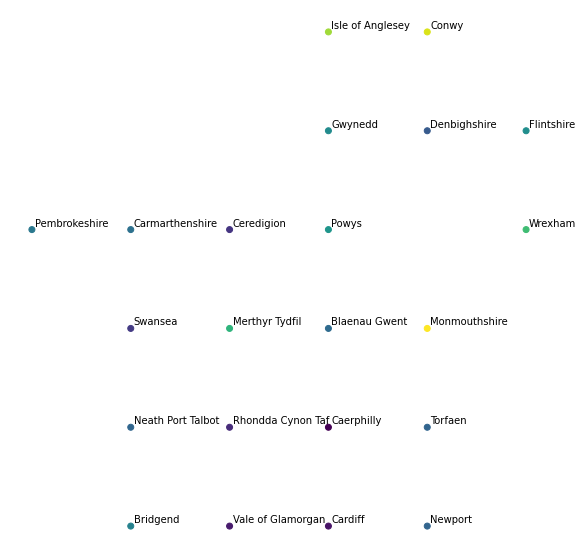

In [47]:
f, ax = plt.subplots(figsize=(10,10))
ax.axis('off')

final = new_df[['code', 'geometry', 'metric']].merge(geodata[['LAD20NM', 'LAD20CD']], left_on='code', right_on='LAD20CD')

final.plot(column='metric', ax=ax)

for x, y, label in zip(final.geometry.x, final.geometry.y, final.LAD20NM):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")